In [310]:
import glob
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import geopandas as gpd
import pandas as pd
import os
import numpy as np
import requests
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

os.chdir("/home/av_data/carto")

# main
import map data

In [264]:
# download shapefile of comarcas from github
url = "https://raw.githubusercontent.com/sirisacademic/catalonia-cartography/master/shapefiles_catalunya_comarcas.geojson"

catalunya_comarcas = gpd.read_file(url)
# map_test = gpd.read_file("./cataluna-latest/gis_osm_pois_a_free_1.shp")
catalunya_comarcas = catalunya_comarcas.sort_values(by='nom_comar')
catalunya_comarcas['nom_comar'] = catalunya_comarcas['nom_comar'].replace("Val d'Aran", "Aran")
catalunya_comarcas = catalunya_comarcas.sort_values(by='nom_comar')
# catalunya_comarcas.head(41)
# catalunya_comarcas.plot(figsize=(5,5))

import study level and nationality data

In [265]:
comarca_2021 = pd.read_csv("./comarca.csv", skiprows=6, encoding='utf-8')
comarca_2021.rename(columns={"Unnamed: 0": "community"}, inplace=True)
# List of communities to filter
communities_to_keep = ["Alt Camp", "Alt Empordà", "Alt Penedès", "Alt Urgell", "Alta Ribagorça", "Aran","Anoia", "Bages", 
                       "Baix Camp", "Baix Ebre", "Baix Empordà", "Baix Llobregat", "Baix Penedès", "Barcelonès", 
                       "Berguedà", "Cerdanya", "Conca de Barberà", "Garraf", "Garrigues", "Garrotxa", "Gironès", 
                       "Maresme", "Moianès", "Montsià", "Noguera", "Osona", "Pallars Jussà", "Pallars Sobirà", 
                       "Pla d'Urgell", "Pla de l'Estany", "Priorat", "Ribera d'Ebre", "Ripollès", "Segarra", 
                       "Segrià", "Selva", "Solsonès", "Tarragonès", "Terra Alta", "Urgell", "Vallès Occidental", 
                       "Vallès Oriental"]

# Filter the data
comarca_2021 = comarca_2021[comarca_2021["community"].isin(communities_to_keep)]
# Convert numeric columns to appropriate data types
numeric_columns_nationality = comarca_2021.columns[2:]  # Assuming the first two columns are non-numeric
comarca_2021[numeric_columns_nationality] = comarca_2021[numeric_columns_nationality].apply(pd.to_numeric, errors='coerce')
# 重みの設定
weights = {
    "Partially completed primary education": 1,
    "Primary education": 2,
    "First stage of secondary education and similar": 3,
    "Second stage of secondary education and similar with general orientation": 4,
    "Second stage of secondary education and similar with professional orientation": 5,
    "Higher-level vocational training and similar education": 6,
    "University bachelor's degree, up to 240 credits, and similar": 7,
    "University degrees of more than 240 credits and similars": 8,
    "Master's degrees and similar": 9,
    "University doctorate": 10
}
key_average = "WeightedEducationalLevel"
levels = list(weights.keys())
for key, coma in comarca_2021.iterrows():
    avg = 0
    for weight in weights:
        # print(coma[weight])
        avg += coma[weight] * weights[weight]
    comarca_2021.at[key, key_average] = avg/coma["Total"]
# comarca_2021.head()
# Normalize the WeightedEducationalLevel
# comarca_2021['WeightedEducationalLevel'] = (comarca_2021['WeightedEducationalLevel']-comarca_2021['WeightedEducationalLevel'].min())/comarca_2021['WeightedEducationalLevel'].max()
catalunya_comarcas_map = catalunya_comarcas.sort_values(by='nom_comar')
catalunya_comarcas_map = catalunya_comarcas_map.merge(comarca_2021, left_on='nom_comar', right_on='community', how='left')
catalunya_comarcas_map = catalunya_comarcas_map.merge(nationality_2021, left_on='nom_comar', right_on='community', how='left')

nationality_2021 = pd.read_csv("./nationality_comarca.csv", skiprows=9, encoding='utf-8')
nationality_2021.rename(columns={"Unnamed: 0": "community"}, inplace=True)

# data = data.drop(index=0)
# data["Municipality of residence"] = data["Municipality of residence"].str.extract(r'(\D+)', expand=False).str.strip()
# Convert numeric columns to appropriate data types
numeric_columns_nationality = nationality_2021.columns[1:]  # Assuming the first two columns are non-numeric
nationality_2021[numeric_columns_nationality] = nationality_2021[numeric_columns_nationality].apply(pd.to_numeric, errors='coerce')
# nationality_2021.rename(columns=lambda x: x.replace(" (%)", ""), inplace=True)
# Normarize
# nationality_2021["Proportion of foreign population"] = (nationality_2021["Proportion of foreign population"]-nationality_2021["Proportion of foreign population"].min())/nationality_2021["Proportion of foreign population"].max()

In [266]:
# Plot the data
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# fig = plt.figure(figsize=(16, 8))
# ax = fig.add_subplot(121)
def plot_education(ax, data):
    ax.set_axis_off()
    data['WeightedEducationalLevel'] = data['WeightedEducationalLevel']
    data.plot(column='WeightedEducationalLevel', 
                          cmap='Blues', 
                          legend=True,
                          legend_kwds={"orientation": "horizontal", "aspect": 50, "pad":0.01},
                          missing_kwds={'color': 'lightgrey', 'label': 'Missing values'}, 
                          ax=ax)
    ax.set_title('Study Level')

def plot_foreigners(ax,data):
    ax.set_axis_off()
    ax.set_title('Proportion of foreign population')
    data.plot(column='Proportion of foreign population (%)', 
                        cmap='Blues', 
                        legend=True,
                        legend_kwds={"orientation": "horizontal", "aspect": 50, "pad":0.01},
                        missing_kwds={'color': 'lightgrey', 'label': 'Missing values'}, 
                        ax=ax)
# plt.show()
polotters = [plot_education, plot_foreigners]
# fig.savefig("cataluna_educational_level.png", dpi=400)

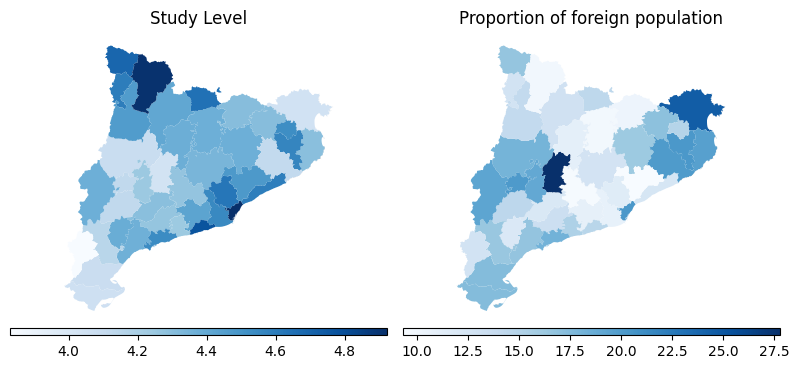

In [267]:
fig = plt.figure(figsize=(8, 4))
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    polotters[i](ax, catalunya_comarcas_map)
fig.tight_layout()
fig.savefig("cataluna_educational_level_and_foreigners.png", dpi=400)

Correlation: -0.31574530243510607, P-value: 0.044324981053420934, Standard Error: 0.15193663523967124


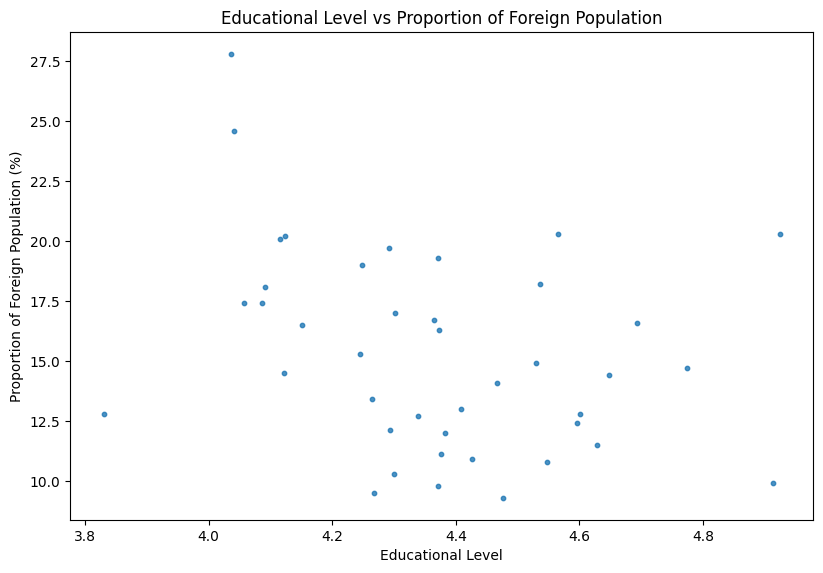

In [304]:
from scipy.stats import pearsonr

fig = plt.figure(figsize=(10/1.2, 7/1.2))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(catalunya_comarcas_map['WeightedEducationalLevel'], catalunya_comarcas_map['Proportion of foreign population (%)'],s=10, alpha=0.8)
ax.set_xlabel('Educational Level')
ax.set_ylabel('Proportion of Foreign Population (%)')

# Check the significance of the correlation
corr, p_value = pearsonr(catalunya_comarcas_map['WeightedEducationalLevel'], catalunya_comarcas_map['Proportion of foreign population (%)'])
stderr = np.sqrt((1 - corr**2) / (len(catalunya_comarcas_map) - 2))
print(f"Correlation: {corr}, P-value: {p_value}, Standard Error: {stderr}")
ax.set_title('Educational Level vs Proportion of Foreign Population')
fig.tight_layout()
fig.savefig("cataluna_educational_level_vs_foreigners.png", dpi=400)

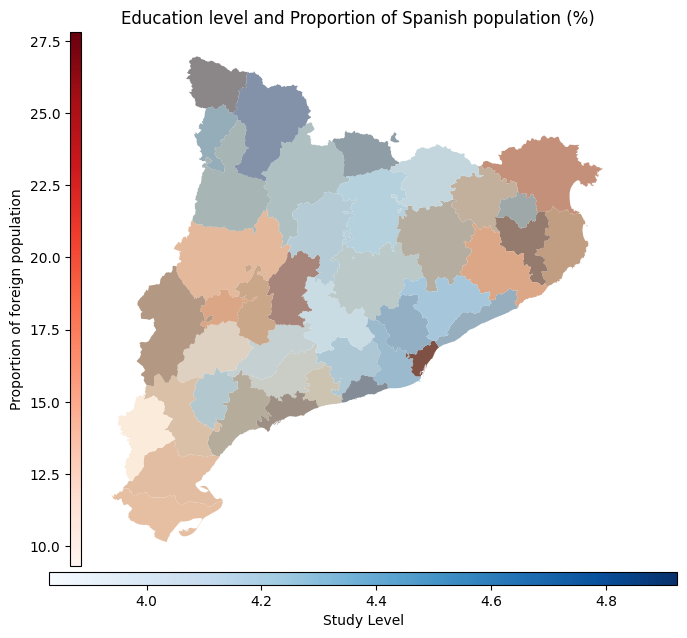

In [308]:
# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
ax.set_axis_off()
norm_study = Normalize(vmin=catalunya_comarcas_map[key_average].min(), vmax=catalunya_comarcas_map[key_average].max())
norm_foreigner = Normalize(vmin=catalunya_comarcas_map["Proportion of foreign population (%)"].min(), vmax=catalunya_comarcas_map["Proportion of foreign population (%)"].max())
colors = np.array([
    np.array(plt.cm.Blues(norm_study(item[key_average])))[:3]*0.5+
    np.array(plt.cm.Oranges(norm_foreigner(item["Proportion of foreign population (%)"])))[:3]*0.5
    for _, item in catalunya_comarcas_map.iterrows()
])
catalunya_comarcas_map.plot(color=colors,ax=ax)

sm_study = ScalarMappable(cmap='Blues', norm=norm_study)
sm_foreginer = ScalarMappable(cmap='Reds', norm=norm_foreigner)

cbar_study = plt.colorbar(sm_study, ax=ax, orientation="horizontal", fraction=0.05, pad=0.01, aspect=50)
cbar_foreginer = plt.colorbar(sm_foreginer, ax=ax, location='left', fraction=0.05, pad=0.01, aspect=50)

cbar_study.set_label('Study Level')
cbar_foreginer.set_label('Proportion of foreign population')
ax.set_title('Education level and Proportion of Spanish population (%)')
fig.tight_layout()
fig.savefig("cataluna_educational_level_and_foreigners_map.png", dpi=400)

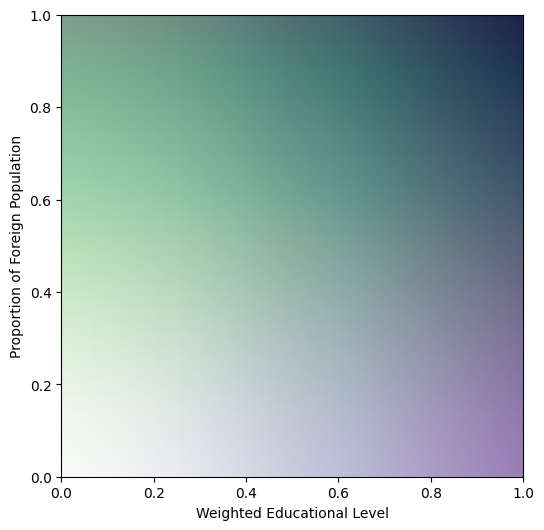

In [269]:
# Create a custom colormap for the 2D legend
cmap_study = plt.cm.Purples
cmap_foreigner = plt.cm.Greens

# Create a figure and axis for the 2D legend
fig, ax = plt.subplots(figsize=(6, 6))

# Create a meshgrid for the 2D legend
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Combine the two colormaps
Z = np.zeros((100, 100, 4))
for i in range(100):
    for j in range(100):
        color_study = cmap_study(X[i, j])
        color_foreigner = cmap_foreigner(Y[i, j])
        Z[i, j, :3] = np.array(color_study)[:3]*0.5 + np.array(color_foreigner)[:3]*0.5  # Use RGB from study colormap
        Z[i, j, 3] = 1  # Set alpha to 1
        
        # Z[i, j, 3] = color_foreigner[3]  # Use alpha from foreigner colormap

# Plot the combined colormap
ax.imshow(Z, extent=[0, 1, 0, 1], origin='lower')

# Add labels and title
ax.set_xlabel('Weighted Educational Level')
ax.set_ylabel('Proportion of Foreign Population')
# ax.set_title('2D Legend for Combined Colormap')

# Create custom patches for the colorbar
patches = [mpatches.Patch(color=cmap_study(0.5), label='Study Level'),
           mpatches.Patch(color=cmap_foreigner(0.5), label='Foreigner Proportion')]

# Add the legend
# ax.legend(handles=patches, loc='upper right')

plt.show()

In [270]:
catalunya_comarcas_map.head(1)

,cartodb_id,comarca,provincia,nom_comar,sup_comar,geometry,community_x,Unlearned,Partially completed primary education,Primary education,...,University doctorate,Total,WeightedEducationalLevel,community_y,Proportion of Spanish population (%),Proportion of foreign population (%),Proportion of population born in Catalonia (%),Proportion of population born in the rest of Spain (%),Proportion of population born abroad (%),Proportion of population born in the same municipality (%)
0,20,1,43,Alt Camp,52.55,"MULTIPOLYGON (((1.35221 41.42784, 1.35576 41.4...",Alt Camp,87,1353,4431,...,222,38208,4.263976,Alt Camp,86.7,13.4,71.4,14.1,14.5,34.3


# Foreginers by provinces

In [271]:
# CSVデータを読み込む
population_data = pd.read_csv("./combined_data.csv")
print(population_data.head())
barcelona = population_data[population_data["Categoria"] == "Barcelona"]
girona = population_data[population_data["Categoria"] == "Girona"]
lleida = population_data[population_data["Categoria"] == "Lleida"]
tarragona = population_data[population_data["Categoria"] == "Tarragona"]
barcelona.head()

# catalunya_map
# merged = catalunya_map.merge(data, how="left", left_on="region_code", right_on="region_code")

   Categoria Population Foreign population. Total  \
0  Barcelona  4.736.276                   121.375   
1     Girona    565.599                    34.933   
2     Lleida    361.590                     9.451   
3  Tarragona    598.533                    15.831   
4      Total  6.261.998                    181.59   

   Foreign population. % vert.  Foreign population. % of (1)  Year  
0                         6684                           256  2000  
1                         1924                           618  2000  
2                          520                           261  2000  
3                          872                           264  2000  
4                        10000                           290  2000  


,Categoria,Population,Foreign population. Total,Foreign population. % vert.,Foreign population. % of (1),Year
0,Barcelona,4.736.276,121.375,6684,256,2000
5,Barcelona,4.804.605,182.242,7082,379,2001
10,Barcelona,4.906.116,275.892,7222,562,2002
15,Barcelona,5.052.665,398.459,7338,789,2003
20,Barcelona,5.117.885,469.236,7299,917,2004


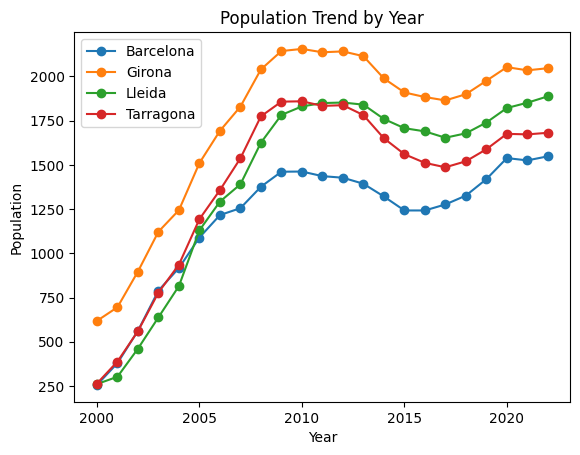

In [272]:
# TODO: make gif of population trend by year
plt.plot(barcelona["Year"], barcelona["Foreign population. % of (1)"], marker='o', label="Barcelona")
plt.plot(girona["Year"], girona["Foreign population. % of (1)"], marker='o', label="Girona")
plt.plot(lleida["Year"], lleida["Foreign population. % of (1)"], marker='o', label="Lleida")
plt.plot(tarragona["Year"], tarragona["Foreign population. % of (1)"], marker='o', label="Tarragona")
plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Population Trend by Year")
# plt.grid(True)
plt.legend()
plt.show()

# Past codes

In [273]:
# # Merge the data with municipio GeoDataFrame
# merged_municipio = municipios.merge(grouped_data, left_on='NAME_4', right_on='Municipality of residence', how='left')
# print(len(merged_municipio))
# # Divide all columns except 'Municipality of residence' by 'Total'
# # columns_to_normalize = merged_municipio.columns.difference(['Municipality of residence', 'geometry'])
# # merged_municipio[columns_to_normalize] = merged_municipio[columns_to_normalize].div(merged_municipio['Total'], axis=0)
# # print(merged_municipio.head())

In [274]:
# # Plot the data
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# ax.set_axis_off()
# merged_municipio['Second stage of secondary education, with general orientation'] = merged_municipio['Second stage of secondary education, with general orientation'] / merged_municipio['Total']
# merged_municipio.plot(column='Second stage of secondary education, with general orientation', 
#                       cmap='Blues', 
#                       legend=True,
#                       missing_kwds={'color': 'lightgrey', 'label': 'Missing values'}, 
#                       ax=ax)
# plt.title('Second stage of secondary education, with general orientation')
# plt.show()

In [275]:
municipios = gpd.read_file("./gadm41_ESP_4.json")
comarca = gpd.read_file("./gadm41_ESP_3.json")

40


<Axes: >

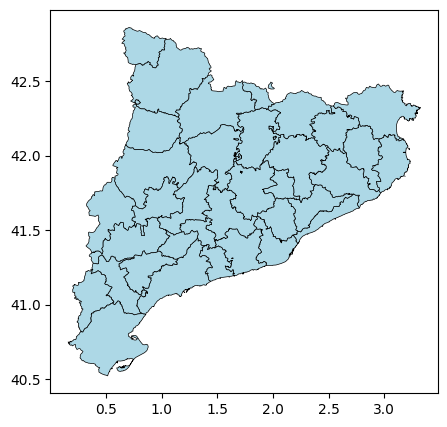

In [276]:
comarca = comarca[comarca["NAME_1"] == "Cataluña"]
print(len(comarca))
comarca.plot(figsize=(5,5), color="lightblue", edgecolor="black", linewidth=0.5)

In [277]:
datas_tmp = []
csv_files = glob.glob("./censuses2021/*.csv")
for file in csv_files:
    print(file)
    data = pd.read_csv(file, skiprows=9, encoding='utf-8')
    data.rename(columns={"Educational attainment (detail)": "Municipality of residence", "Unnamed: 1": "Country of origin (large groups)"}, inplace=True)
    data = data.drop(index=0)
    data["Municipality of residence"] = data["Municipality of residence"].str.extract(r'(\D+)', expand=False).str.strip()
    # Convert numeric columns to appropriate data types
    numeric_columns_nationality = data.columns[2:]  # Assuming the first two columns are non-numeric
    data[numeric_columns_nationality] = data[numeric_columns_nationality].apply(pd.to_numeric, errors='coerce')
    datas_tmp.append(data)

./censuses2021/Censuses2021Barcelona.csv
./censuses2021/Censuses2021Girona.csv
./censuses2021/Censuses2021LLeida.csv
./censuses2021/Censuses2021Tarragona.csv


In [278]:
data.groupby("Municipality of residence").sum().sort_values("Total", ascending=False).shape

(34, 15)

In [279]:
datas = []
csv_files = glob.glob("./censuses2021/*.csv")
for file in csv_files:
    # print(file)
    data = pd.read_csv(file, skiprows=9, encoding='utf-8')
    data.rename(columns={"Educational attainment (detail)": "Municipality of residence", "Unnamed: 1": "Country of origin (large groups)"}, inplace=True)
    data = data.drop(index=0)
    data["Municipality of residence"] = data["Municipality of residence"].str.extract(r'(\D+)', expand=False).str.strip()
    # Convert numeric columns to appropriate data types
    numeric_columns_nationality = data.columns[2:]  # Assuming the first two columns are non-numeric
    data[numeric_columns_nationality] = data[numeric_columns_nationality].apply(pd.to_numeric, errors='coerce')
    datas.append(data)
# datas[0]
combined_datas = pd.concat(datas, ignore_index=True)

dictionary_municipio = dict()
dictionary_nationality = dict()


# for name in combined_datas["Municipality of residence"]:
#     dictionary_municipio[name] = 0
    
# for name in dictionary_municipio:
#     combined_datas.loc[(combined_datas["Municipality of residence"] == name) & (combined_datas["Country of origin (large groups)"] != "Not applicable: has alwarys lived in Spain"), "Country of origin (large groups)"] = "not spain"
#     # Group by 'Municipality of residence' and sum the 'not spain' values
#     grouped_data = combined_datas[combined_datas["Country of origin (large groups)"] == "not spain"].groupby("Municipality of residence").sum(numeric_only=True).reset_index()
    
#     # Update dictionary_municipio with the summed values
#     # for name in dictionary_municipio:
#         # if name in grouped_data["Municipality of residence"].values:
#             # dictionary_municipio[name] = grouped_data[grouped_data["Municipality of residence"] == name]["Total"].values[0]
#     # print(grouped_data.head())

# for name in sorted(dictionary_municipio):
#     print(name)

<Axes: >

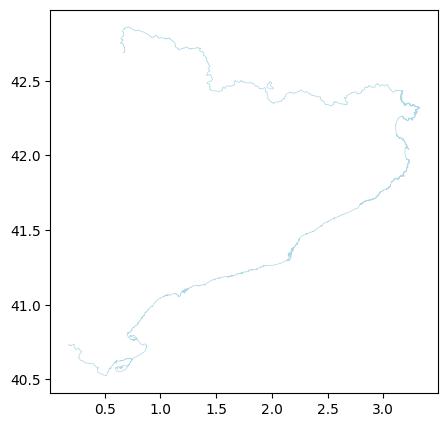

In [280]:

path = "./lineas_limite/SHP_ETRS89/ll_autonomicas_inspire_peninbal_etrs89/ll_autonomicas_inspire_peninbal_etrs89.shp"
comarca_test = gpd.read_file(path)
comarca_test = comarca_test[~comarca_test['NAME_BOUND'].str.startswith(
    ('Galicia', 'Cantabria', 'Región de Murcia', 'Illes Balears', 'Canarias', 'Andalucía', 'Extremadura', 'Castilla-La Mancha', 'Castilla y León', 'Madrid', 'Aragón', 'Comunidad Valenciana', 'Asturias', 'La Rioja', 'Navarra', 'País Vasco', 'Comunitat Valenciana', "Principado de Asturias", 'Territorio no asociado a ninguna autonomía', "Comunidad Foral de Navarra", "Ciudad Autónoma de Ceuta", "Ciudad Autónoma de Melilla", "Gibraltar"))]
# for coma in comarca_test.NAME_BOUND:
#     print(coma)
# comarca_test = comarca_test[comarca_test['NAME_BOUND'].str.startswith('Cataluña')]
# comarca_test = comarca[comarca["NAME_"] == "Cataluña"]
# print(comarca_test["NAME_1"])
# comarca_test
comarca_test.plot(figsize=(5,5), color="lightblue", edgecolor="black", linewidth=0.5)

In [281]:
# os.chdir("/home/av_data/carto")
# # CSVファイルが保存されているディレクトリのパス
# directory_path = "./demography/"

# # ディレクトリ内のすべてのCSVファイルをリストとして取得
# csv_files = glob.glob(directory_path + "*.csv")
# # 各CSVファイルを読み込み、1つのDataFrameに結合
# df_list = []
# for file in csv_files:
#     match = re.search(r"y(\d{4})", file)
#     if match:
#         year = match.group(1)
#         df = pd.read_csv(file, skiprows=5, encoding='utf-8')
#         df['Year'] = year  # 年の列を追加
#         df_list.append(df)
#     else:
#         print(f"Year not found in filename: {file}")
# # for df in df_list:
# #     print(df)
# combined_df = pd.concat(df_list, ignore_index=True)

# combined_df
# # print(df_list)
# combined_df.to_csv(directory_path+"combined_data.csv", index=False)